In [2]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import numpy as np
import pandas as pd
import sys
import pickle as pkl
import matplotlib.pyplot as plt
import os 
# sys.path.append('/zfsauton2/home/mgoswami/PyMAD/') # TODO: Make this relative path maybe
sys.path.append('/zfsauton2/home/mgoswami/tsad-model-selection/src')
sys.path.append('/zfsauton2/home/mgoswami/tsad-model-selection/VUS/')

from model_selection.model_selection import RankModels
from model_trainer.entities import ANOMALY_ARCHIVE_ENTITIES, ANOMALY_ARCHIVE_ENTITY_TO_DATA_FAMILY
from model_selection.utils import visualize_predictions, visualize_data
from model_selection.rank_aggregation import trimmed_borda, trimmed_kemeny, trimmed_partial_borda, borda, kemeny, partial_borda, influence, averagedistance
from metrics.metrics import evaluate_model_selection

ModuleNotFoundError: No module named 'PyMAD'

In [1]:
SAVE_DIR = r'/home/scratch/mgoswami/'
exp = 'allmetric' # 'Oct25' 'Oct29', 'Nov3' 'VUS' 'F1' 'reliability' 'allmetric'
dataset = 'anomaly_archive' # 'anomaly_archive' 'smd'

with open(os.path.join(SAVE_DIR, f'Experiments_{exp}', f"aggregate_stats_{dataset}.pkl"), 'rb') as f:
    aggregate_stats = pkl.load(f)

NameError: name 'pkl' is not defined

In [4]:
### Load the ranking object

DATASET = 'anomaly_archive'
ENTITY = '028_UCR_Anomaly_DISTORTEDInternalBleeding17'
EXPERIMENT_DATE = 'Oct29'
SAVE_DIR = f'/home/scratch/mgoswami/Experiments_{EXPERIMENT_DATE}/results'
ranking_obj_file = f'ranking_obj_{ENTITY}.data'

with open(os.path.join(SAVE_DIR, DATASET, ranking_obj_file), 'rb') as f: 
    rankingObj = pkl.load(f)

visualize_data(train_data=rankingObj.train_data, test_data=rankingObj.test_data)

In [117]:
import math
import numpy as np
import pandas as pd
from vus.models.feature import Window
from vus.metrics import get_range_vus_roc
from vus.utils.slidingWindows import find_length
from sklearn.preprocessing import MinMaxScaler

In [5]:
def anomaly_results(X_data):
    # Isolation Forest
    # from vus.models.iforest import IForest
    from sklearn.ensemble import IsolationForest
    clf = IsolationForest(random_state=0, n_jobs=5)    
    x = X_data
    clf.fit(x)
    IF_score = -clf.score_samples(x)
    
    return IF_score


def scoring(score, labels, slidingWindow):
    # Score normalization
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    results = get_range_vus_roc(score, labels, slidingWindow)

    return results

In [100]:
### Load the ranking object
DATASET = 'anomaly_archive'
EXPERIMENT_DATE = 'Oct29'
SAVE_DIR = f'/home/scratch/mgoswami/Experiments_{EXPERIMENT_DATE}/results'

with open(os.path.join(SAVE_DIR, 'correlation.pkl'), 'rb') as f: 
    correlations = pkl.load(f)
print(f'Processed datasets: {len(correlations)}')

Processed datasets: 250


In [101]:
positively_correlated = 0
negatively_correlated = 0

negatively_correlated_entities = []
for i in range(len(correlations)):
    spearman_r = correlations[i]['spearman_correlation']
    spearman_pval = correlations[i]['spearman_pvalue']
    
    if (spearman_r is not None) and (spearman_pval < 0.05):
        if spearman_r > 0:
            positively_correlated += 1
        else:
            negatively_correlated += 1
            negatively_correlated_entities.append([i, correlations[i]['entity']])

print(f'Positively correlated datasets: {positively_correlated}, negatively correlated datasets: {negatively_correlated}')

Positively correlated datasets: 78, negatively correlated datasets: 23


In [108]:
positively_correlated = 0
negatively_correlated = 0
negatively_correlated_entities = []

for i in range(len(correlations)):
    kendall_tau = correlations[i]['kendall_correlation']
    kendall_pval = correlations[i]['kendall_pvalue']
    
    if (kendall_tau is not None) and (kendall_pval < 0.05):
        # print('Correlation:', np.around(kendall_tau, 3), 'p-value:', np.around(kendall_pval, 3))
    
        if kendall_tau > 0:
            positively_correlated += 1
        else:
            negatively_correlated += 1
            negatively_correlated_entities.append([i, correlations[i]['entity']])

print(f'Positively correlated datasets: {positively_correlated}, negatively correlated datasets: {negatively_correlated}')

Positively correlated datasets: 80, negatively correlated datasets: 23


In [166]:
low_dispersion = 0
neg_corr_ent_with_high_dis = []
dispersion_threshold = 0.2
dispersion = []

for i, ent in negatively_correlated_entities: 
    measures = correlations[i]['model_performance_matrix']
    dispersion_f1 = np.quantile(measures.loc[:, 'Best F-1'], 0.75) - np.quantile(measures.loc[:, 'Best F-1'], 0.25)
    dispersion_vus = np.quantile(measures.loc[:, 'VUS'], 0.75) - np.quantile(measures.loc[:, 'VUS'], 0.25)
    if (dispersion_f1 < dispersion_threshold) or (dispersion_vus < dispersion_threshold):
        low_dispersion = low_dispersion + 1
    else: 
        neg_corr_ent_with_high_dis.append(i) 
    
    dispersion.append(min(dispersion_f1, dispersion_vus)) 

print(f'Number of low dispersion datasets: {low_dispersion} our of {len(negatively_correlated_entities)}' )

Number of low dispersion datasets: 22 our of 23


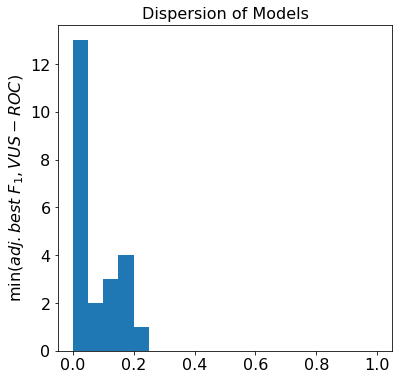

In [172]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.hist(dispersion, bins=20, range=(0,1), color='darkblue')
axes.set_ylabel(r'$\min(adj. best \ F_1, VUS-ROC)$', fontsize=16)
axes.set_title(f'Dispersion of Models', fontsize=16)
axes.tick_params(labelsize=16)

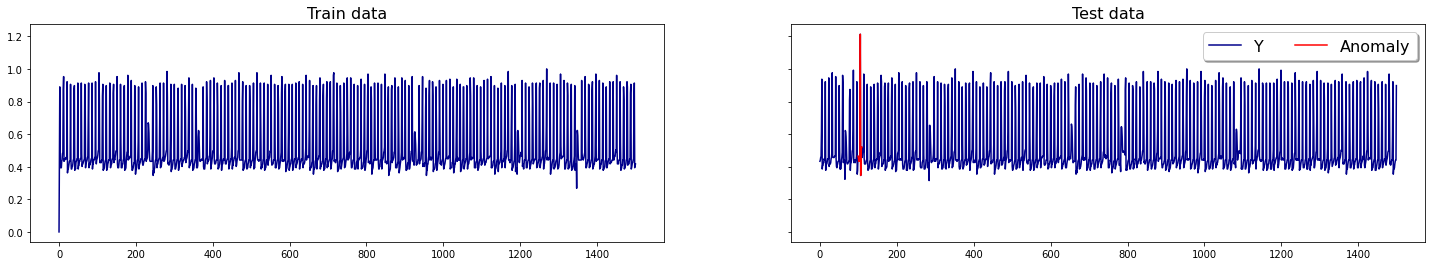

Sliding window length (train): 9
Sliding window length (test): 9


In [153]:
### Load the ranking object
DATASET = 'anomaly_archive'
i = 229
ENTITY = correlations[i]['entity']
EXPERIMENT_DATE = 'Oct29'
SAVE_DIR = f'/home/scratch/mgoswami/Experiments_{EXPERIMENT_DATE}/results'
ranking_obj_file = f'ranking_obj_{ENTITY}.data'

with open(os.path.join(SAVE_DIR, DATASET, ranking_obj_file), 'rb') as f: 
    rankingObj = pkl.load(f)

visualize_data(train_data=rankingObj.train_data, test_data=rankingObj.test_data)

print('Sliding window length (train):', find_length(rankingObj.train_data.entities[0].Y.flatten()))
print('Sliding window length (test):',find_length(rankingObj.test_data.entities[0].Y.flatten()))

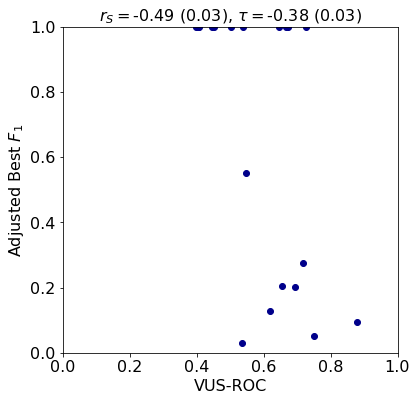

In [154]:
for i in neg_corr_ent_with_high_dis:
    fig, axes = plt.subplots(1, 1, figsize=(6, 6))
    entity = correlations[i]['entity']
    measures = correlations[i]['model_performance_matrix']
    spearman_r = correlations[i]['spearman_correlation']
    spearman_pval = correlations[i]['spearman_pvalue']
    kendall_tau = correlations[i]['kendall_correlation']
    kendall_pval = correlations[i]['kendall_pvalue']
    axes.scatter(measures.loc[:, 'VUS'], measures.loc[:, 'Best F-1'], c='darkblue') # 
    axes.set_xlim(0, 1)
    axes.set_ylim(0, 1)
    axes.set_xlabel('VUS-ROC', fontsize=16)
    axes.set_ylabel(r'Adjusted Best $F_1$', fontsize=16)
    axes.set_title(r'$r_S = $' + f'{np.around(spearman_r, 2)} ({np.around(spearman_pval, 2)}), ' + r'$\tau = $' + f'{np.around(kendall_tau, 2)} ({np.around(kendall_pval, 2)})', fontsize=16)
    axes.tick_params(labelsize=16)